## **Sequence-to-sequence learning : FR to EN translation** - revision 02
## **Using pre-trained models**

### **1. Small_vocab translation**

In [9]:
import os

def load_data(path):

    # Nombre maximum de lignes à renvoyer
    max_lines = 140000
    
    input_file = os.path.join(path)
    with open(input_file, "r",  encoding="utf-8") as f:
        data = f.read()
   
    data = data.split('\n')
    return data[:min(len(data),max_lines)]

In [10]:


# Indication de calculer le score Bleu
bleu_score_to_do = True

# Chargement des textes dans les 2 langues (max lignes = max_lines)
src = 'en'
tgt = 'fr'
txt_tgt = load_data('../data/small_vocab_'+tgt)
txt_src = load_data('../data/small_vocab_'+src)

text_pairs = []
for line in range(len(txt_src)):
    text_pairs.append((txt_src[line], "[start] " + txt_tgt[line] + " [end]" ))
    

In [11]:
import random
print(random.choice(text_pairs))
print(random.choice(text_pairs))

('she likes grapefruit , bananas , and lemons .', '[start] elle aime le pamplemousse , les bananes et les citrons . [end]')
('she likes mangoes , oranges , and limes .', '[start] elle aime les mangues , les oranges et les citrons verts . [end]')


**Vectorizing the English and French text pairs**

In [12]:
import tensorflow as tf
import string
import re
from tensorflow import keras
from tensorflow.keras import layers

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    lowercase=tf.strings.regex_replace(lowercase, "[à]", "a")
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

def load_vocab(file_path):
    with open(file_path, "r",  encoding="utf-8") as file:
        return file.read().split('\n')[:-1]

vocab_size = 15000
sequence_length = 30

source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
    standardize=custom_standardization,
    vocabulary = load_vocab("../data/vocab_"+src+".txt"),
)

target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
    vocabulary = load_vocab("../data/vocab_"+tgt+".txt"),
)

source_texts = [pair[0] for pair in text_pairs]
target_texts = [pair[1] for pair in text_pairs]


**Defining Sample sentences for translation**

In [13]:
input_sentence=[]
for i in range(20):
    input_sentence.append(random.choice(source_texts))

### **2. Sequence-to-sequence learning with RNNs**

**Loading of the trained RNN model**

In [14]:
# seq2seq_rnn = keras.models.load_model("../data/seq2seq_rnn-model-"+src+"-"+tgt+".h5")

from filesplit.merge import Merge
merge = Merge( "../data/rnn_"+src+"-"+tgt+"_split",  "../data", "seq2seq_rnn-model-"+src+"-"+tgt+".h5").merge(cleanup=False)
seq2seq_rnn = keras.models.load_model("../data/seq2seq_rnn-model-"+src+"-"+tgt+".h5")


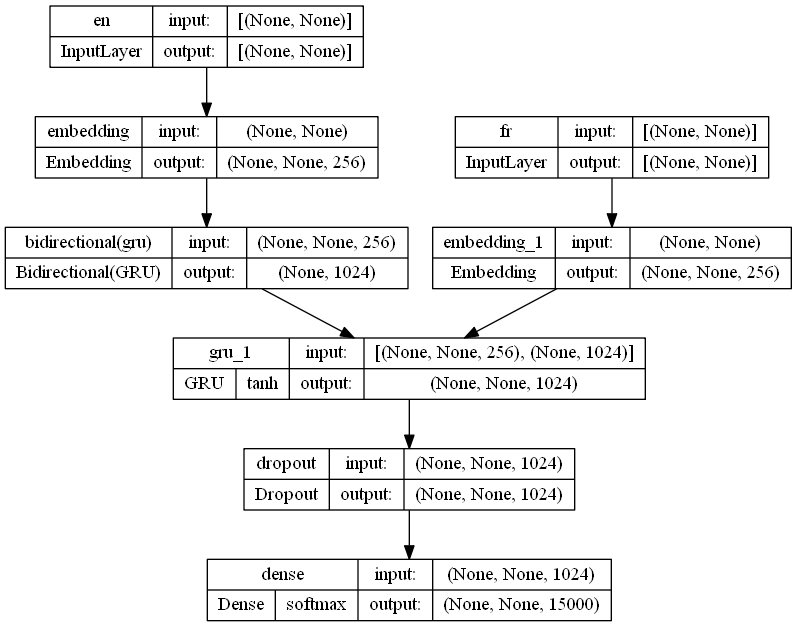

In [15]:
# seq2seq_rnn.summary()
from keras.utils.vis_utils import plot_model
plot_model(seq2seq_rnn, show_shapes=True, show_layer_names=True, show_layer_activations=True,rankdir='TB')  # to_file='../images/seq2seq_model_plot.png'


**Translating new sentences with our RNN encoder and decoder**

In [9]:
import numpy as np

def decode_sequence_rnn(input_sentence):
    tgt_vocab = target_vectorization.get_vocabulary()
    tgt_index_lookup = dict(zip(range(len(tgt_vocab)), tgt_vocab))
    max_decoded_sentence_length = 50
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])
        next_token_predictions = seq2seq_rnn.predict(
            [tokenized_input_sentence, tokenized_target_sentence], verbose=0)
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])
        sampled_token = tgt_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence[8:-6]

for i in range(20):
    print("-")
    print(src.upper()+"  ",input_sentence[i])
    print(tgt.upper()+"->",decode_sequence_rnn(input_sentence[i]))

-
FR   la chine est parfois agréable au cours de l' automne , mais il gèle jamais en juin .
EN-> china is sometimes pleasant during autumn but it is never freezing in june
-
FR   paris est jamais froid en décembre , et il est parfois le gel en août .
EN-> paris is never chilly during december and it is sometimes freezing in august
-
FR   la chine est relaxant au mois de mai , mais il fait froid à l' automne .
EN-> china is relaxing during may but it is cold in fall
-
FR   mon fruit le plus aimé est la fraise , mais son plus aimé est la chaux .
EN-> my most loved fruit is the strawberry but her most loved is the lime
-
FR   pourquoi at - elle aller en chine ?
EN-> why did she go to china
-
FR   les états-unis est parfois chaud en juillet , mais il est parfois merveilleux en août .
EN-> the united states is sometimes warm during july but it is sometimes wonderful in august
-
FR   je prévois de visiter new jersey en février .
EN-> i plan to visit new jersey in february
-
FR   la chine est

<br></br>
**You turn to play:** Enter a sentence..

In [18]:
if src=='fr':
    your_sentence1 = "paris est pluvieux pendant l'été, mais la france n'est jamais magnifique en hiver" 
    your_sentence2 = "new jersey est parfois calme pendant l' automne , et il est neigeux en avril ." 
else:
    your_sentence1 = "paris is rainy during summer , and france is never wonderful in winter"
    your_sentence2 = "new jersey is sometimes quiet during autumn , and it is snowy in april ."
    
print(tgt.upper()+"->",decode_sequence_rnn(your_sentence1))
print(tgt.upper()+"->",decode_sequence_rnn(your_sentence2))

EN-> paris is rainy during winter but it is never wonderful in winter
EN-> new jersey is sometimes quiet during autumn and it is snowy in april


### **3. Sequence-to-sequence learning with Transformer**

#### The Transformer decoder

**The `TransformerDecoder`**

In [11]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        else:
            padding_mask = mask
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

#### Putting it all together: A Transformer for machine translation

**PositionalEmbedding layer**

In [12]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

**Loading of the trained Transformer model**

In [13]:
from keras_nlp.layers import TransformerEncoder
transformer = keras.models.load_model(
    "../data/transformer-model-"+src+"-"+tgt+".h5",
    custom_objects={"PositionalEmbedding": PositionalEmbedding, "TransformerDecoder": TransformerDecoder},
)
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
transformer.load_weights("../data/transformer-model-"+src+"-"+tgt+".weights.h5")


Using TensorFlow backend


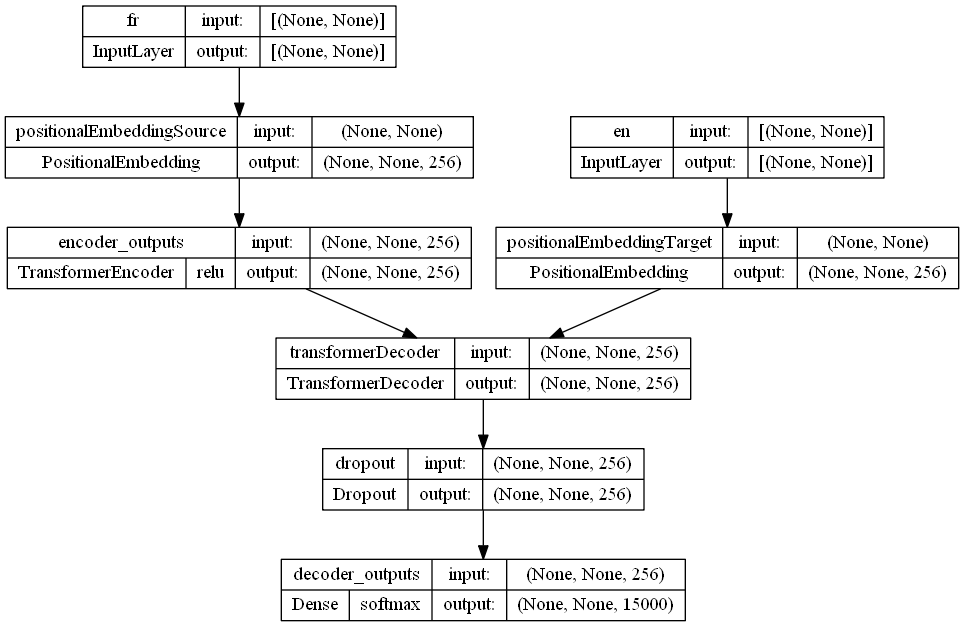

In [14]:
# transformer.summary()
from keras.utils.vis_utils import plot_model
plot_model(transformer, show_shapes=True, show_layer_names=True, show_layer_activations=True,rankdir='TB')  # to_file='../images/transformer_model_plot.png'

**Translating new sentences with our Transformer model**

In [15]:
import numpy as np

def decode_sequence_tranf(input_sentence):
    tgt_vocab = target_vectorization.get_vocabulary()
    tgt_index_lookup = dict(zip(range(len(tgt_vocab)), tgt_vocab))
    max_decoded_sentence_length = 30
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = tgt_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence[8:-6]

for i in range(20):
    print("-")
    print(src.upper()+"  ",input_sentence[i])
    print(tgt.upper()+"->",decode_sequence_tranf(input_sentence[i]))

-
FR   la chine est parfois agréable au cours de l' automne , mais il gèle jamais en juin .
EN-> china is sometimes pleasant during autumn but it is never freezing in june
-
FR   paris est jamais froid en décembre , et il est parfois le gel en août .
EN-> paris is never chilly during december and it is sometimes freezing in august
-
FR   la chine est relaxant au mois de mai , mais il fait froid à l' automne .
EN-> china is relaxing during may but it is cold in fall
-
FR   mon fruit le plus aimé est la fraise , mais son plus aimé est la chaux .
EN-> my most loved fruit is the strawberry but her most loved is the lime
-
FR   pourquoi at - elle aller en chine ?
EN-> why did she go to china
-
FR   les états-unis est parfois chaud en juillet , mais il est parfois merveilleux en août .
EN-> the united states is sometimes warm during july but it is sometimes wonderful in august
-
FR   je prévois de visiter new jersey en février .
EN-> i plan to visit new jersey in february
-
FR   la chine est

<br></br>
**You turn to play:** Enter a sentence..

In [17]:
if src=='fr':
    your_sentence1 = "paris est pluvieux pendant l'été, mais la france n'est jamais magnifique en hiver" 
    your_sentence2 = "new jersey est parfois calme pendant l' automne , et il est neigeux en avril ." 
else:
    your_sentence1 = "paris is rainy during summer , and france is never wonderful in winter"
    your_sentence2 = "new jersey is sometimes quiet during autumn , and it is snowy in april ."

print(tgt.upper()+"->",decode_sequence_tranf(your_sentence1))
print(tgt.upper()+"->",decode_sequence_tranf(your_sentence2))

EN-> paris is rainy during summer but it is never warm in winter
EN-> new jersey is sometimes quiet during autumn and it is snowy in april
